In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
os.chdir("/content/drive/MyDrive/WORK/Meta_Explainer/Meta-Explainer")
import sys
sys.path.append('/content/drive/MyDrive/WORK/Meta_Explainer/Meta-Explainer')
sys.path

['/content',
 '/env/python',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/local/lib/python3.11/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.11/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/WORK/Meta_Explainer/Meta-Explainer']

In [34]:
!pip install tf-keras-vis tensorflow
!pip install lime
!pip install shap
!pip install innvestigate

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
^C
^C
^C
^C


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.applications.vgg16 as vgg16

from skimage.color import gray2rgb, rgb2gray, label2rgb

from Metrics.LSE_Analysis import lse_calculate
from Images.Relevance.explanations_functions.gradcam_explainer import gradcam_explanations_and_lse_all_classes
from Images.Relevance.explanations_functions.lrp_explainer import lrp_explanations_and_lse_all_classes
from Images.Relevance.explanations_functions.lime_explainer import lime_explanations_and_lse_all_classes
from Images.Relevance.explanations_functions.shap_explainer import shap_explanations_and_lse_all_classes
from aux_functions import visualize_explanations_horizontal_with_original, visualize_all_classes, save_explanations_to_pkl, load_explanations_from_pkl, ensure_single_channel, normalize_map, is_valid_map

from Images.Integrations import owa_integrations, union_owa_integrations, intersection_owa_integrations

#Reading Data and Model (MNIST)



In [4]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# For use with Lime and Shap
x_train_rgb = np.stack([gray2rgb(img) for img in x_train], axis=0)
x_test_rgb = np.stack([gray2rgb(img) for img in x_test], axis=0)

# Convert to Keras-compatible format (add channel dimension for RGB images)
x_train_rgb = x_train_rgb[..., np.newaxis].reshape(-1, 28, 28, 3)
x_test_rgb = x_test_rgb[..., np.newaxis].reshape(-1, 28, 28, 3)

# Preprocess the data
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [5]:
# Load model and weights separately
loaded_model = keras.models.load_model("Images/Model/mnist_model_architecture.h5")
loaded_model.load_weights("Images/Model/mnist_model_weights.h5")

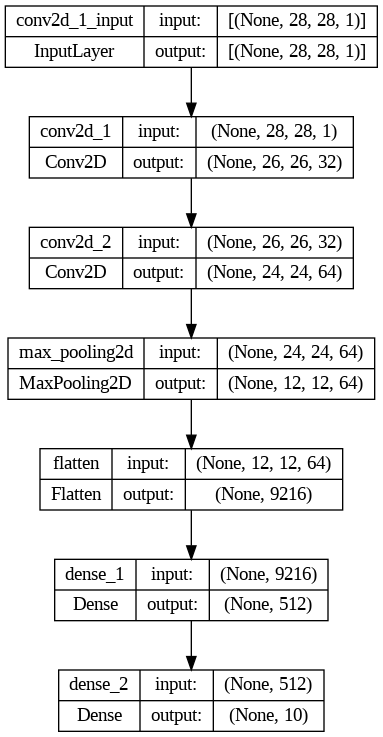

In [6]:
# Visualize the model and save the image
plot_model(loaded_model, to_file="model_topology.png", show_shapes=True, show_layer_names=True)

#Instance Selection (MNIST)

1/1 [==============================] - 0s 24ms/step


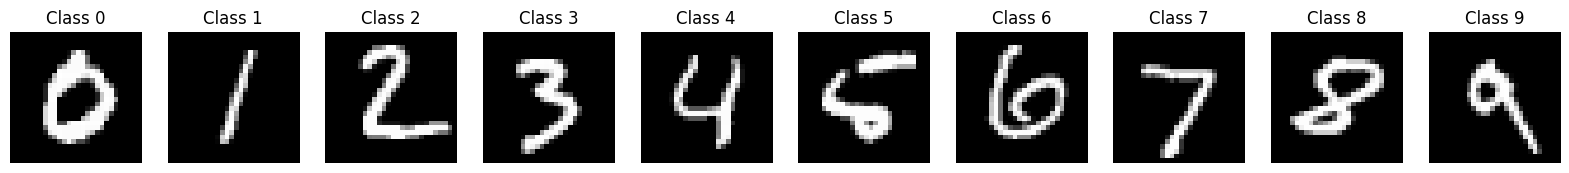

In [7]:
# Function to select a correctly classified image for each class
def select_correctly_classified_images(x_test, y_test, model):
    selected_images = []
    selected_labels = []

    for i in range(10):  # Iterate through all classes (0-9)
        # Get the indices of images belonging to class i
        indices = np.where(y_test == i)[0]

        for idx in indices:
            image = x_test[idx]
            label = y_test[idx]
            # Predict the class using the model
            prediction = np.argmax(model.predict(image[np.newaxis, ...]), axis=1)[0]

            if prediction == label:
                selected_images.append(image)
                selected_labels.append(label)
                break  # Move to the next class once a correctly classified image is selected

    return np.array(selected_images), np.array(selected_labels)

# Select one correctly classified image per class
x_selected, y_selected = select_correctly_classified_images(x_test, y_test, loaded_model)
x_selected_rgb = np.stack([gray2rgb(img) for img in x_selected], axis=0)

# Visualize the selected images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_selected[i].squeeze(), cmap='gray')
    plt.title(f'Class {y_selected[i]}')
    plt.axis('off')
plt.show()

# Individual Explanations


##GRADCAM++

In [ ]:
# Call to generate GradCAM++ for all classes
gradcam_explanations, lse_gradcam = gradcam_explanations_and_lse_all_classes(
    loaded_model,
    x_selected,
    y_selected,
    threshold=0.85)

In [ ]:
lse_gradcam = [item[0] for item in lse_gradcam]

print(lse_gradcam)
sum= np.sum(lse_gradcam)
prom= sum/10
print(f"Promedio: {prom}")

In [ ]:
# Verify and adjust lse_value if they are greater than 9.5
gradcam_explanations_data = {
    'explanations': gradcam_explanations,
    'lse_value': [min(value, 9.5) for value in lse_gradcam]  # Replace values greater than 9.5 with 9.5
}

save_explanations_to_pkl(gradcam_explanations_data, "Images/Relevance/explanations_pkl/gradcam_explanation_data.pkl")

##LRP

In [ ]:
tf.compat.v1.disable_eager_execution()  # Disable eager execution for compatibility with certain TensorFlow operations

# Load model and weights
loaded_model = keras.models.load_model("Images/Model/mnist_model_architecture.h5")
loaded_model.load_weights("Images/Model/mnist_model_weights.h5")

# Run LRP for all selected images
lrp_explanations, lse_lrp = lrp_explanations_and_lse_all_classes(
    loaded_model,
    x_selected,
    y_selected,
    threshold=0.85)

In [ ]:
lse_lrp = [item[0] for item in lse_lrp]

print(lse_lrp)
sum= np.sum(lse_lrp)
prom= sum/10
print(f"Promedio: {prom}")

In [ ]:
# Verify and adjust lse_value if they are greater than 9.5
lrp_explanations_data = {
    'explanations': lrp_explanations,
    'lse_value': [min(value, 9.5) for value in lse_lrp]  # Replace values greater than 9.5 with 9.5
}

save_explanations_to_pkl(lrp_explanations_data, "Images/Relevance/explanations_pkl/lrp_explanation_data.pkl")

##LIME

In [ ]:
# Call to generate LIME explanations for all classes
lime_explanations, lse_lime = lime_explanations_and_lse_all_classes(
    loaded_model,
    x_selected_rgb,
    y_selected,
    threshold=0.85)

In [ ]:
lse_lime = [item[0] for item in lse_lime]

print(lse_lime)
sum= np.sum(lse_lime)
prom= sum/10
print(f"Promedio: {prom}")

In [ ]:
# Verify and adjust lse_value if they are greater than 9.5
lime_explanations_data = {
    'explanations': lime_explanations,
    'lse_value': [min(value, 9.5) for value in lse_lime]  # Replace values greater than 9.5 with 9.5
}

save_explanations_to_pkl(lime_explanations_data, "Images/Relevance/explanations_pkl/lime_explanation_data.pkl")

##SHAP

In [ ]:
# Call to generate SHAP explanations for all classes
shap_explanations, lse_shap = shap_explanations_and_lse_all_classes(
    loaded_model,
    x_selected,
    x_train,
    y_selected,
    thershold = 0.85)

In [ ]:
lse_shap = [item[0] for item in lse_shap]

print(lse_shap)
sum= np.sum(lse_shap)
prom= sum/10
print(f"Promedio: {prom}")

In [ ]:
# Verify and adjust lse_value if they are greater than 9.5
shap_explanations_data = {
    'explanations': shap_explanations,
    'lse_value':  [min(value, 9.5) for value in lse_shap]  # Replace values greater than 9.5 with 9.5
}

save_explanations_to_pkl(shap_explanations_data, "Images/Relevance/explanations_pkl/shap_explanation_data.pkl")


# Reading Explanations

In [8]:
# List of paths to explanation files
explanation_paths = [
    "Images/Relevance/explanations_pkl/gradcam_explanation_data.pkl",
    "Images/Relevance/explanations_pkl/lrp_explanation_data.pkl",
    "Images/Relevance/explanations_pkl/lime_explanation_data.pkl",
    "Images/Relevance/explanations_pkl/shap_explanation_data.pkl"
]

# Load the explanations
new_explanations_data = [load_explanations_from_pkl(path) for path in explanation_paths]

Explicaciones cargadas desde Images/Relevance/explanations_pkl/gradcam_explanation_data.pkl
Explicaciones cargadas desde Images/Relevance/explanations_pkl/lrp_explanation_data.pkl
Explicaciones cargadas desde Images/Relevance/explanations_pkl/lime_explanation_data.pkl
Explicaciones cargadas desde Images/Relevance/explanations_pkl/shap_explanation_data.pkl


# INTEGRATION

##OWA

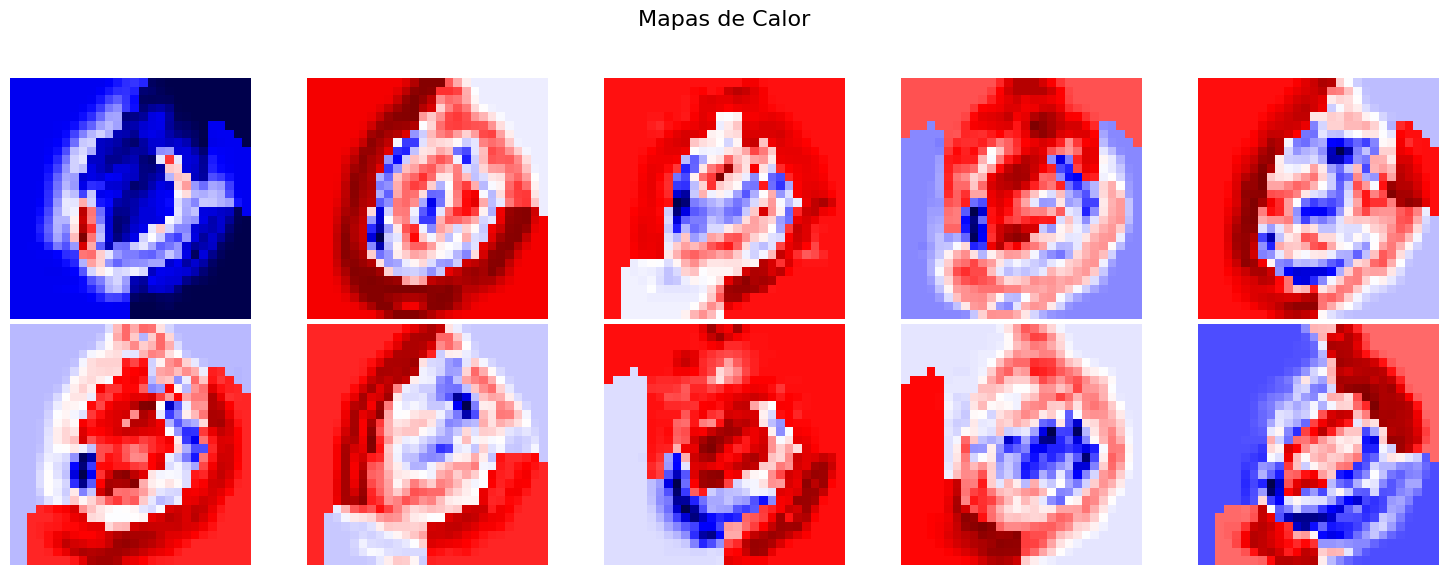

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 4
Indices mayores que 0.85: [428 456 484 512]
Suma clase objetivo: 3.623459232118263
Suma de otras clases: 10.53828797005111
IFI calculado: 3.094538048470714


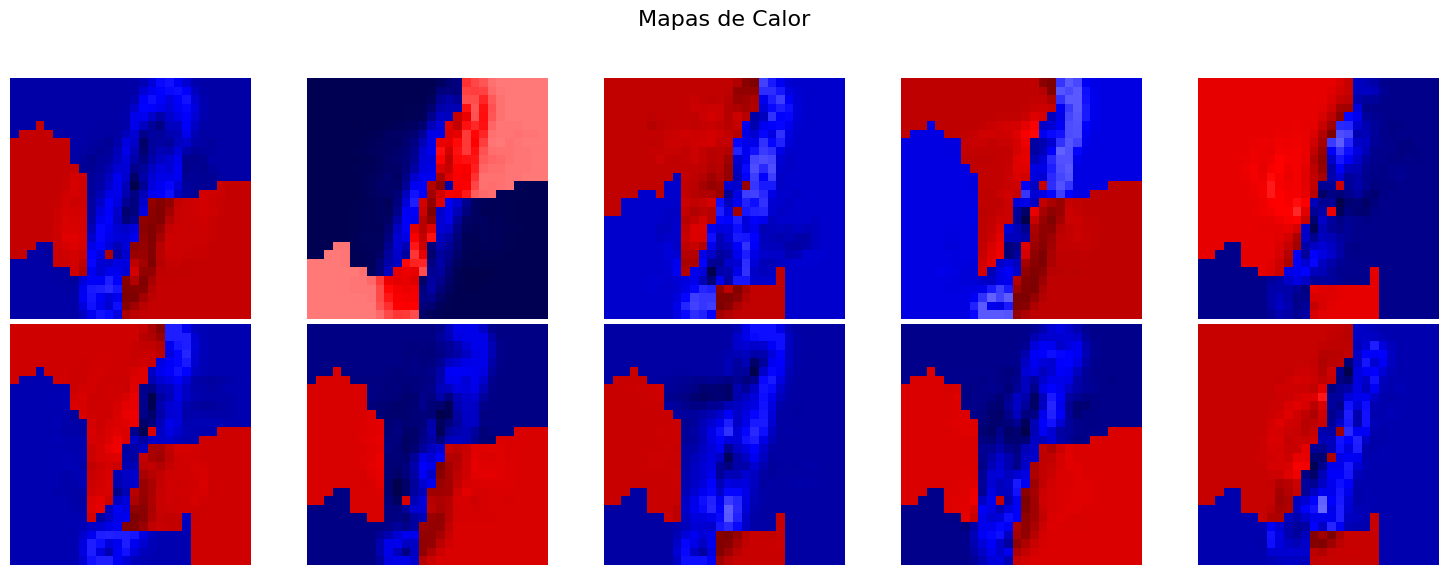

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 14
Indices mayores que 0.85: [129 157 268 296 323 350 351 378 406 434 461 462 489 517]
Suma clase objetivo: 12.709935819602144
Suma de otras clases: 17.490960633555115
IFI calculado: 6.539916518762935


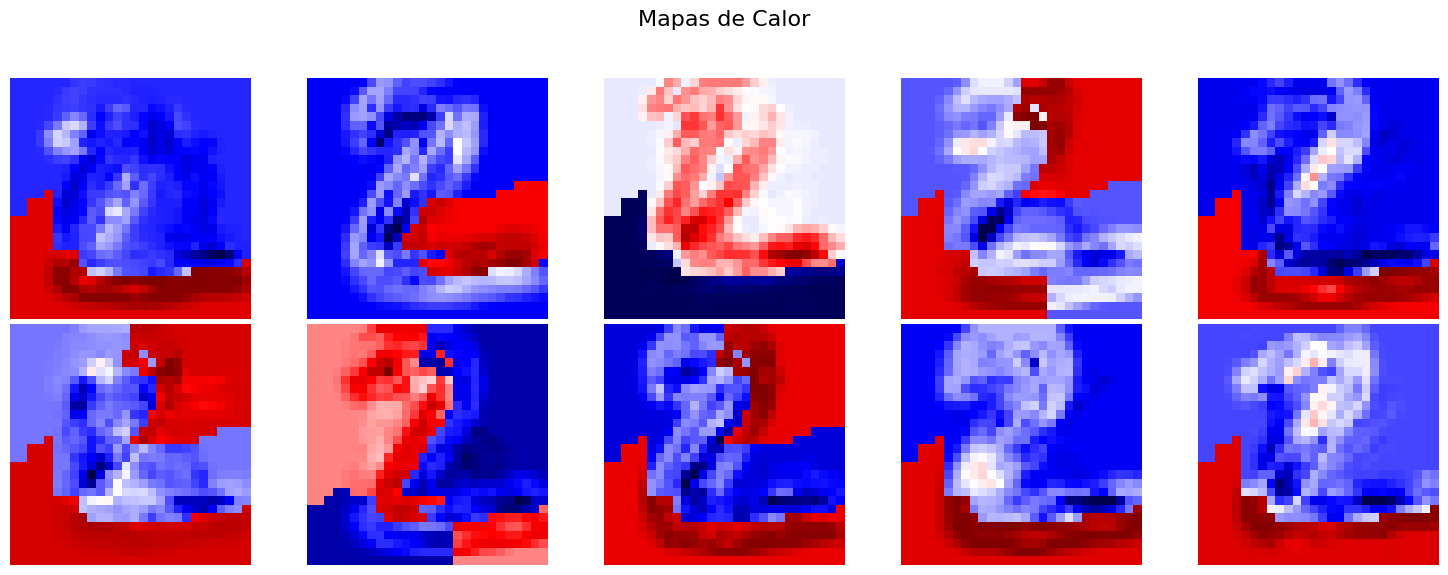

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 9
Indices mayores que 0.85: [485 486 513 579 580 581 582 583 584]
Suma clase objetivo: 8.263493921710124
Suma de otras clases: 16.87370341555858
IFI calculado: 4.407535409613525


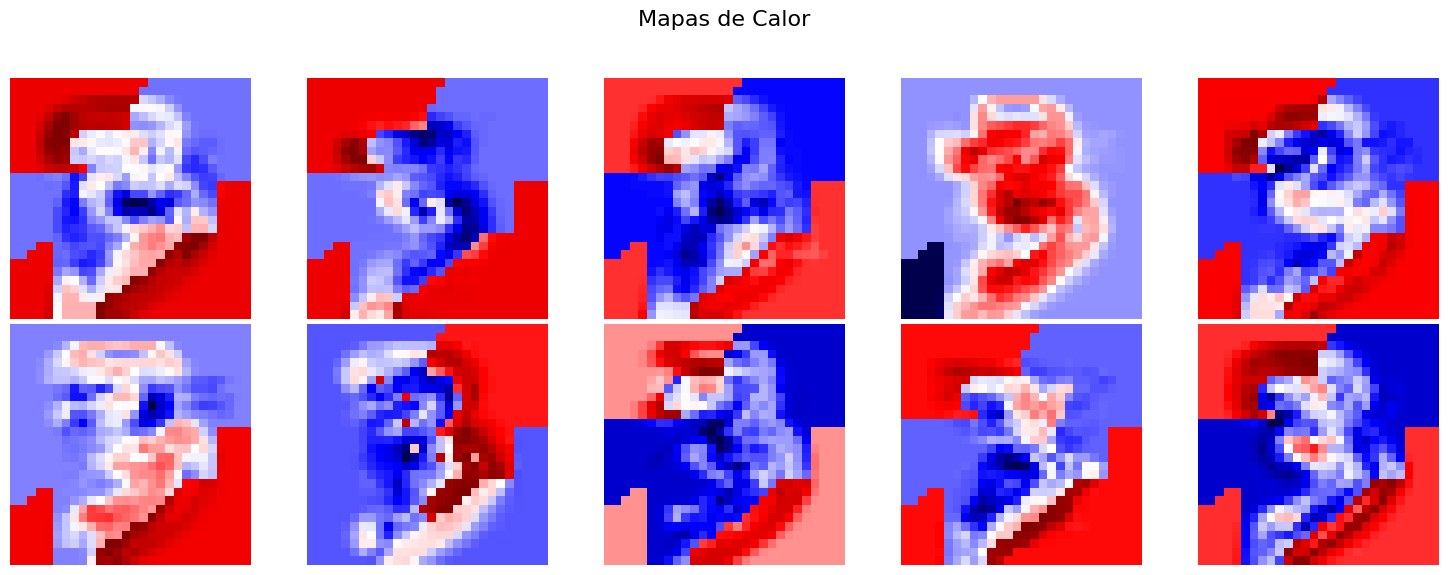

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 17
Indices mayores que 0.85: [232 376 404 405 406 407 408 409 431 432 433 434 460 461 462 463 628]
Suma clase objetivo: 15.545558921303424
Suma de otras clases: 52.84901407925081
IFI calculado: 2.6473536494347067


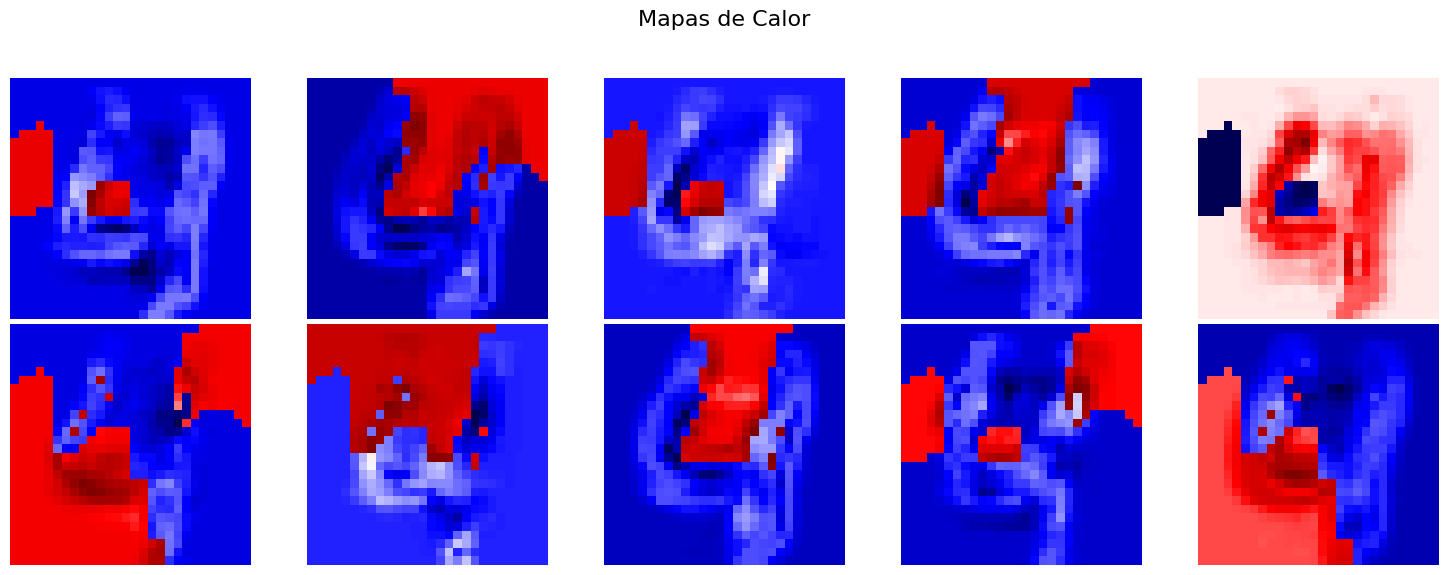

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 15
Indices mayores que 0.85: [179 180 206 207 208 234 235 236 262 289 316 344 428 456 605]
Suma clase objetivo: 13.509772982135644
Suma de otras clases: 48.82315889226424
IFI calculado: 2.490374641827728


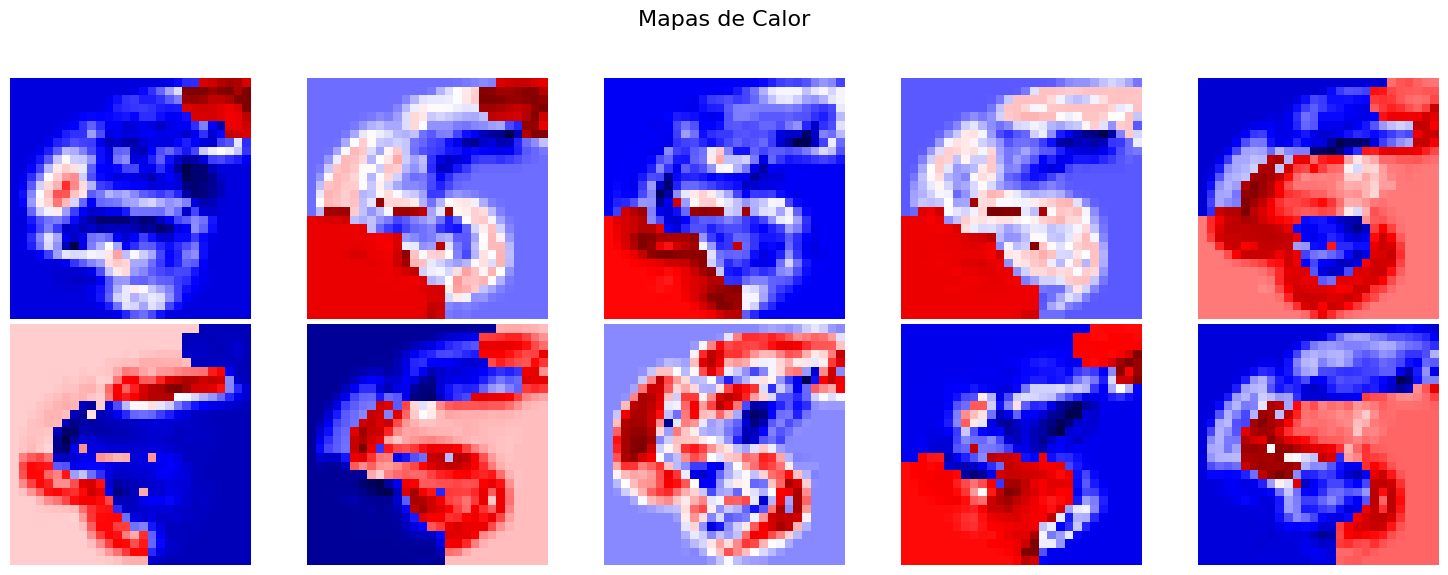

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 12
Indices mayores que 0.85: [187 188 189 191 212 213 214 215 216 240 241 242]
Suma clase objetivo: 10.89835954997635
Suma de otras clases: 29.895316335441056
IFI calculado: 3.280956617057321


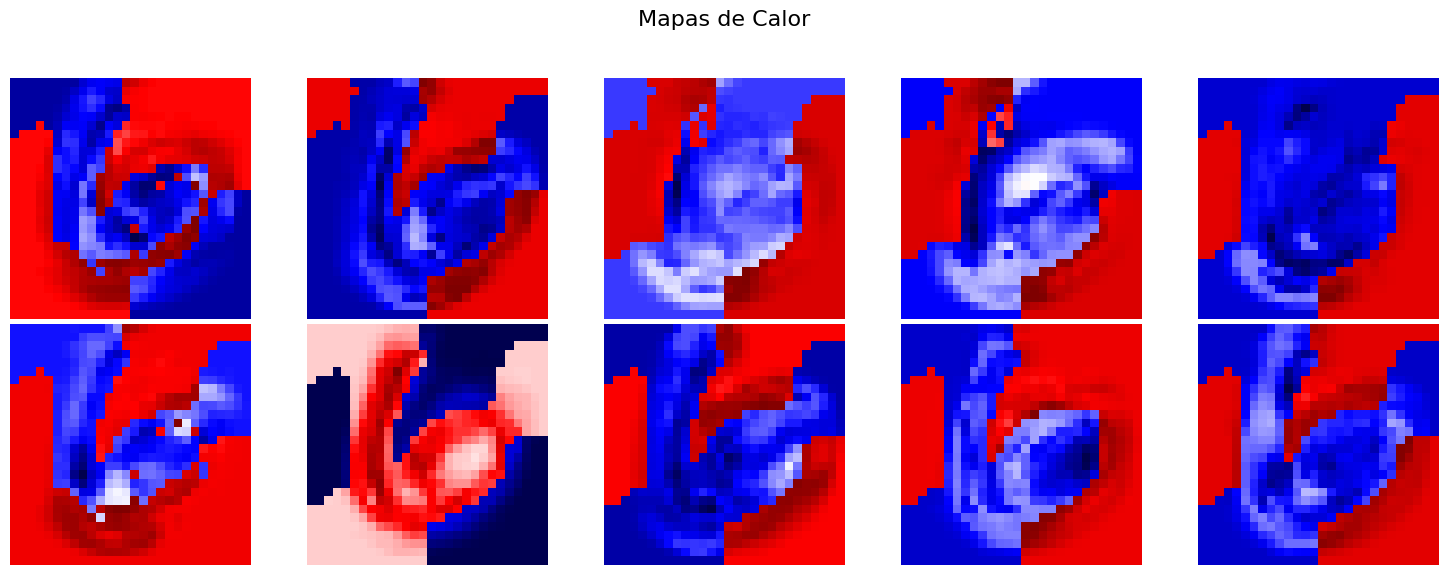

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 30
Indices mayores que 0.85: [ 95 123 150 177 178 205 206 233 260 261 288 316 344 371 372 399 400 427
 428 432 455 456 460 461 483 484 511 512 540 568]
Suma clase objetivo: 27.11156579111296
Suma de otras clases: 58.095211009136776
IFI calculado: 4.200072396357102


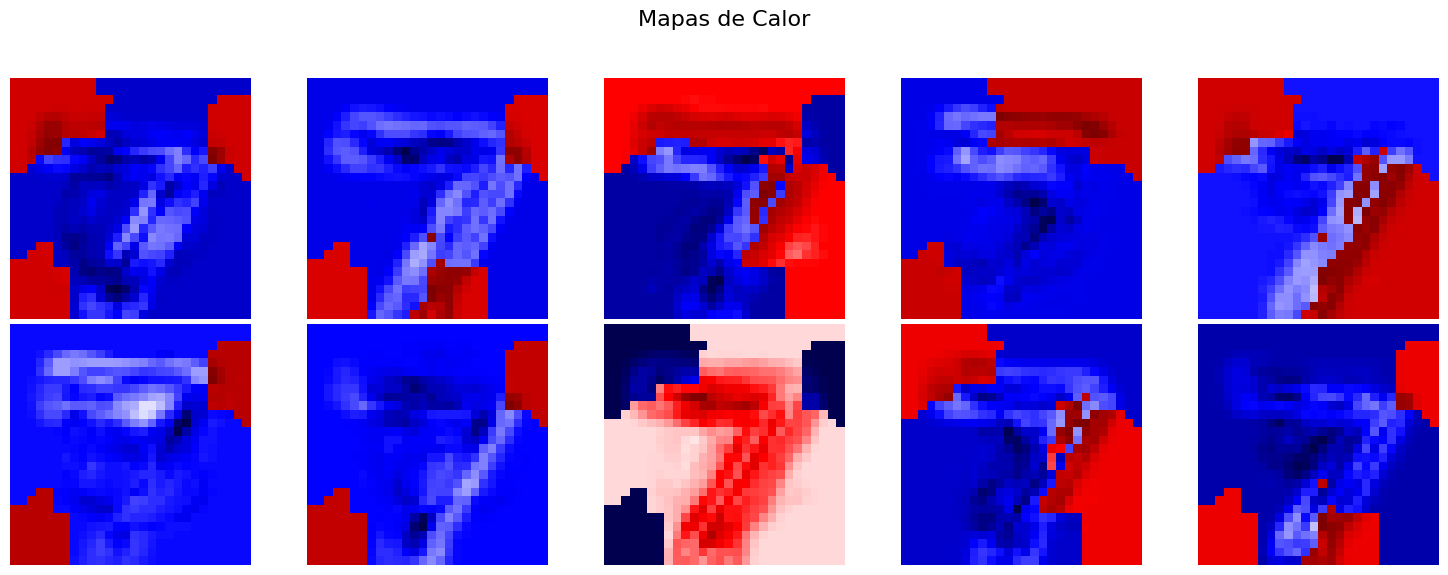

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 12
Indices mayores que 0.85: [233 234 235 236 263 264 265 266 267 268 269 684]
Suma clase objetivo: 11.01062592774449
Suma de otras clases: 20.716472359118445
IFI calculado: 4.783422178828773


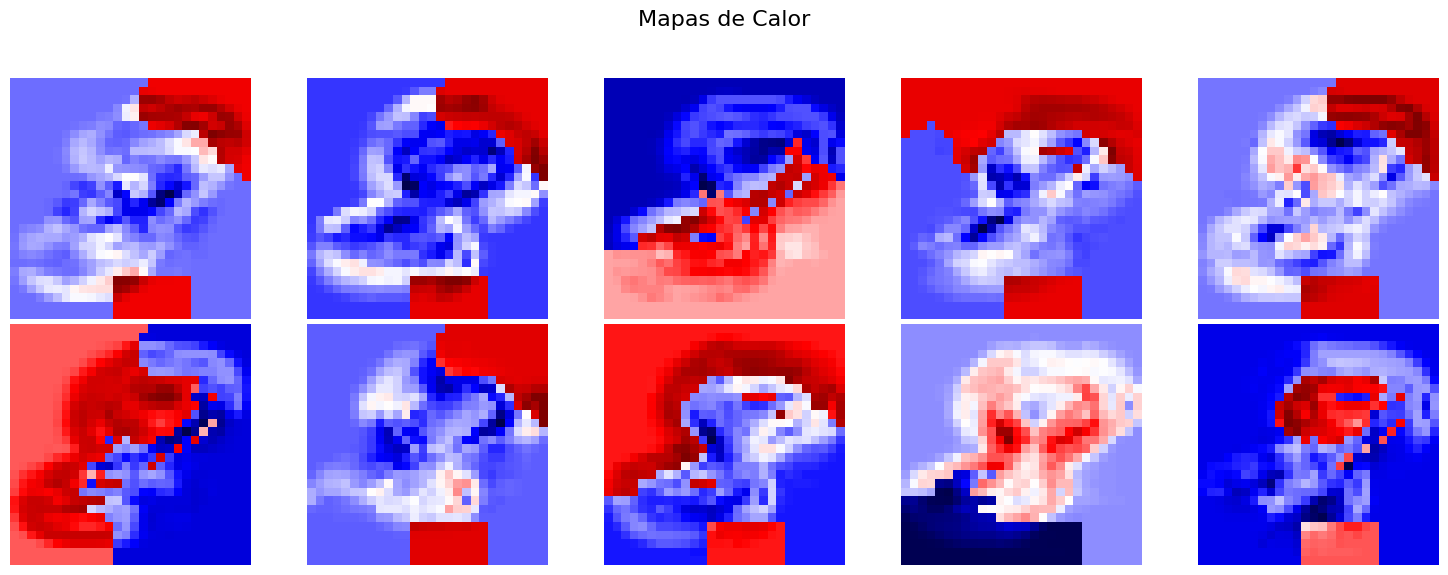

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 3
Indices mayores que 0.85: [347 348 376]
Suma clase objetivo: 2.8756059663209905
Suma de otras clases: 8.75500481437171
IFI calculado: 2.9560753244138778


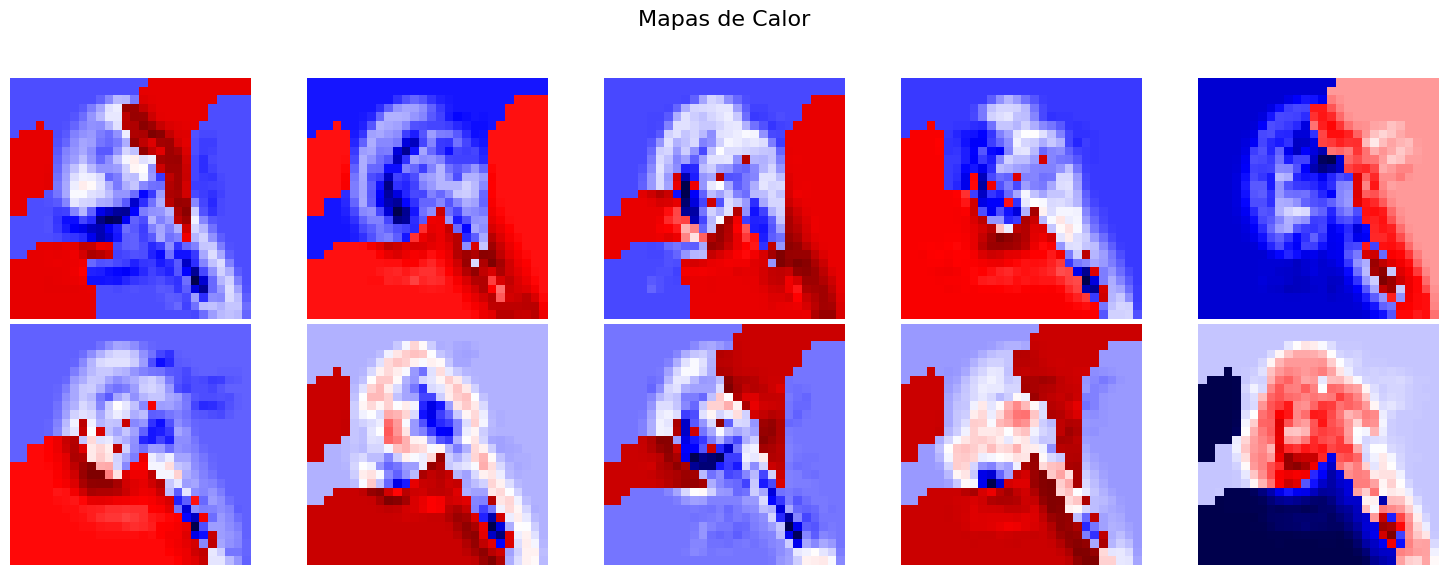

Forma original de relevances: (10, 28, 28)
Mapas válidos (incluyendo ceros para inválidos): 10
Cantidad de mapas inválidos: 0
Forma mapas válidos: (10, 28, 28)
Forma de relevancias aplanadas: (10, 784)
Forma de relevancia clase: (784,)
Mapa 0: Max: 1.0, Min: 0.0
Mapa 1: Max: 1.0, Min: 0.0
Mapa 2: Max: 1.0, Min: 0.0
Mapa 3: Max: 1.0, Min: 0.0
Mapa 4: Max: 1.0, Min: 0.0
Mapa 5: Max: 1.0, Min: 0.0
Mapa 6: Max: 1.0, Min: 0.0
Mapa 7: Max: 1.0, Min: 0.0
Mapa 8: Max: 1.0, Min: 0.0
Mapa 9: Max: 1.0, Min: 0.0
Cantidad de rasgos mayores que 0.85: 12
Indices mayores que 0.85: [430 431 432 433 458 459 460 514 637 665 666 694]
Suma clase objetivo: 10.942821677245982
Suma de otras clases: 37.694099659522195
IFI calculado: 2.6127536135575187


In [9]:
# Use weighted sum
integrated_explanations_sum, lse_integrated_sum = owa_integrations.calculate_lse_integrated_explanations(
    explanations_data=new_explanations_data,
    y_selected=y_selected,
    threshold_lse=0.85,
    method="weighted_sum"
)

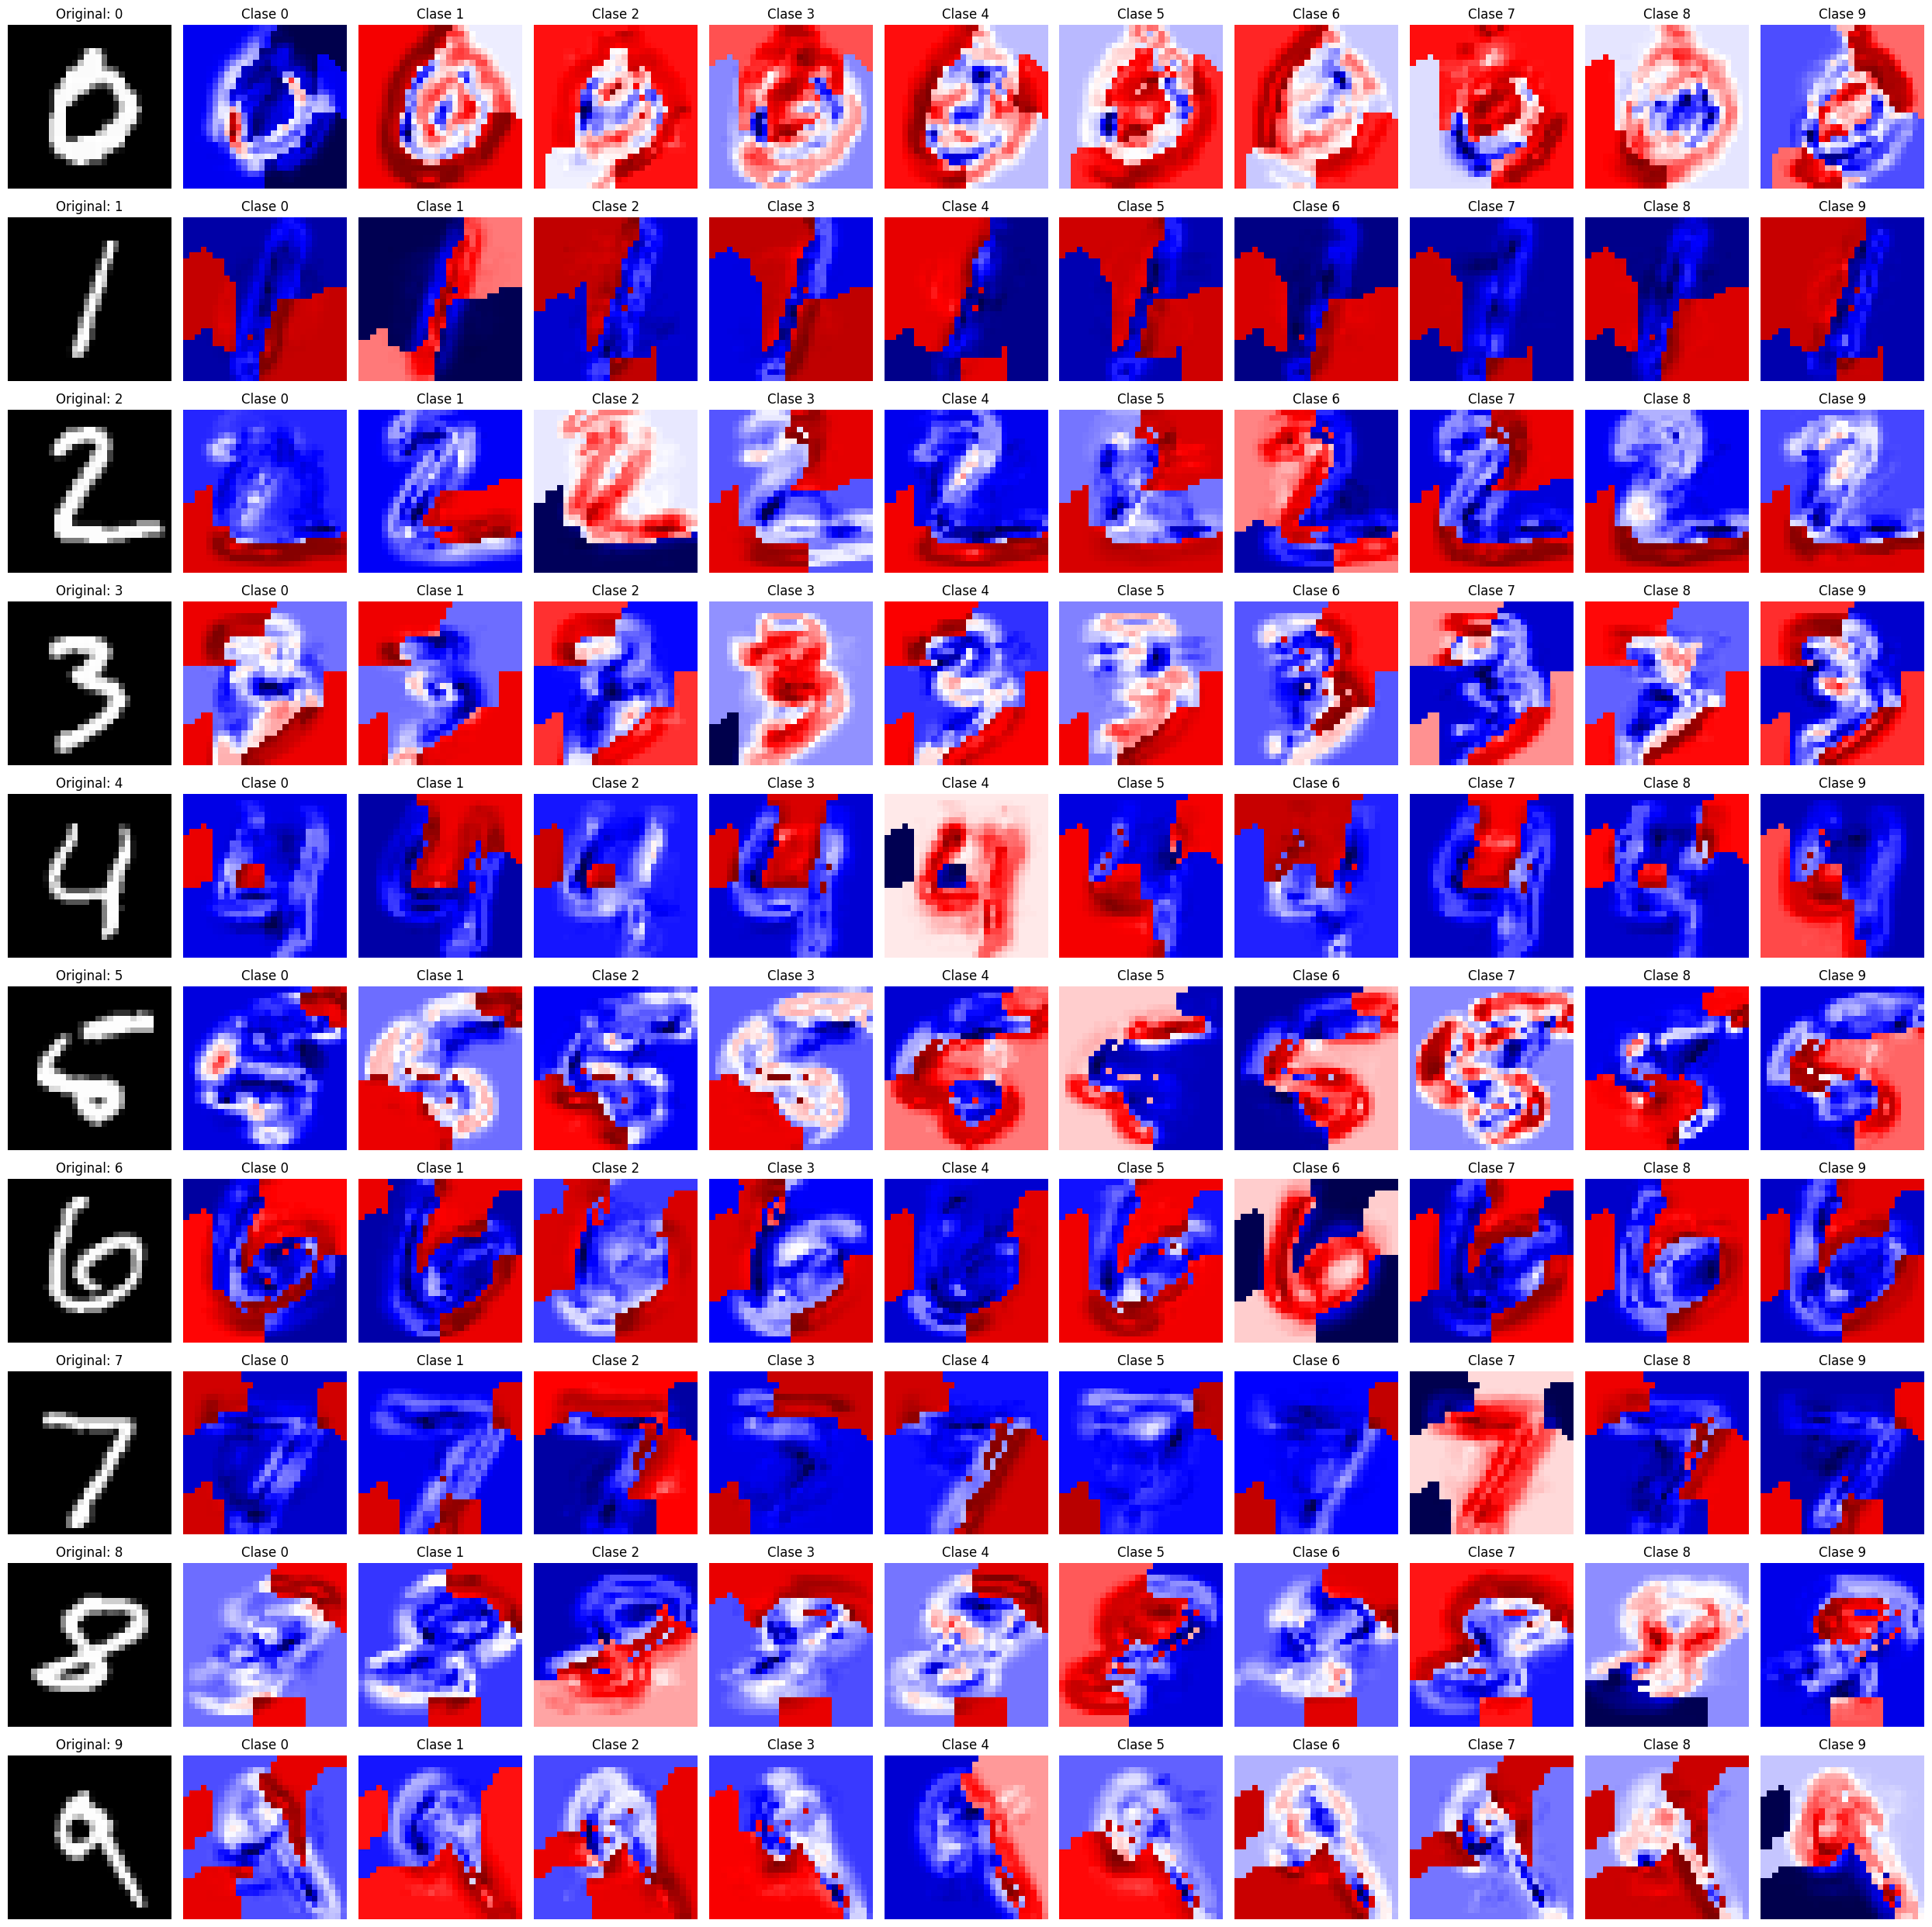

In [10]:
visualize_all_classes(integrated_explanations_sum, x_selected, y_selected)

In [11]:
# Use weighted average
# integrated_explanations_average, lse_integrated_average = owa_integrations.calculate_lse_integrated_explanations(
#     explanations_data=explanations_data,
#     y_selected=y_selected,
#     threshold_lse= 0.85,
#     method="weighted_average"
# )


In [12]:
# use simple average
# integrated_explanations_simple, lse_integrated_simple = owa_integrations.calculate_lse_integrated_explanations(
#     explanations_data=explanations_data,
#     y_selected=y_selected,
#     threshold_lse= 0.85,
#     method="simple_average"
# )

##UNION

In [ ]:
# Execute the calculation to obtain the integrated explanations and integrated LSE
# Use weighted sum
integrated_explanations_union, lse_integrated_union = union_owa_integrations.calculate_lse_union_integrated_explanations(
    explanations_data=new_explanations_data,
    y_selected=y_selected,
    threshold=0.85,
    operator="sum"
)

In [ ]:
# Use Max
# union_max_exp, union_max_lse = union_owa_integrations.calculate_lse_union_integrated_explanations(
#     new_explanations_data,
#     y_selected,
#     threshold=0.75,
#     operator="max"
#     )

##Intersección

In [ ]:
#Use weighted sum
integrated_explanations_intersection, lse_integrated_intersection = intersection_owa_integrations.calculate_lse_intersection_integrated_explanations(
    explanations_data=new_explanations_data,
    y_selected=y_selected,
    threshold = 0.85,
    operator = 'sum'
)

##Max


In [ ]:
def calculate_max_per_pixel(explanations_data):
    """
    Calculates the pixel-wise maximum across all explanations for each image and class.
    Includes prints of dimensions and max/min values at each step.

    Args:
        explanations_data (list of dict): Contains explanations from the 4 methods.
                                          Each dict element contains 'explanations' and 'lse_value'.
                                          'explanations' has dimensions (10, 10, 28, 28).

    Returns:
        integrated_explanations (list of numpy.ndarray): List of integrated heatmaps using the maximum.
    """
    num_images = len(explanations_data[0]['explanations'])  # Number of images (10)
    num_classes = len(explanations_data[0]['explanations'][0])  # Number of classes (10)
    integrated_explanations = []  # To store the integrated results

    for image_idx in range(num_images):  # Iterate through each image
        print(f"\nProcessing image {image_idx + 1}/{num_images}...")
        image_maps = []  # Integrated maps per class for this image

        for class_idx in range(num_classes):  # Iterate through each class
            print(f"  Class {class_idx + 1}/{num_classes}:")

            # Collect heatmaps from the 4 methods for the same image and class
            class_maps = []
            for method_idx in range(len(explanations_data)):  # len(explanations_data) == 4
                map_ = explanations_data[method_idx]['explanations'][image_idx][class_idx]
                single_channel_map = ensure_single_channel(map_)
                normalized_map = normalize_map(single_channel_map)

                # Add to the list of maps
                class_maps.append(normalized_map)

                # Print details of the processed map
                print(f"    Method {method_idx + 1}: Shape: {normalized_map.shape}")#, "
                #       f"Min: {np.min(normalized_map):.4f}, Max: {np.max(normalized_map):.4f}")

            # Convert the maps to a NumPy array (dimensions: (4, 28, 28))
            stacked_maps = np.stack(class_maps, axis=0)

            # Calculate the pixel-wise maximum along axis 0 (across the 4 methods)
            max_map = np.max(stacked_maps, axis=0)  # Dimensions: (28, 28)

            # Print details of the integrated map
            print(f"    Integrated map: Shape: {max_map.shape}, "
                  f"Min: {np.min(max_map):.4f}, Max: {np.max(max_map):.4f}")

            # Save the integrated map per class
            image_maps.append(max_map)

        # Save the integrated maps for all classes of this image
        integrated_explanations.append(image_maps)

    return integrated_explanations

In [ ]:
max_explanations = calculate_max_per_pixel(new_explanations_data)

In [ ]:
visualize_all_classes(max_explanations,x_selected, y_selected)

In [ ]:
def calculate_lse_per_image(integrated_explanations, y_selected):
    """
    Calculates the LSE value for each image based on the integrated heatmaps and the selected class.

    Args:
        integrated_explanations (list of list): List of integrated heatmaps (10 images, 10 classes, 28, 28).
        y_selected (list of int): List of selected classes for each image (10 values, one per image).

    Returns:
        lse_values (list of float): List of calculated LSE values for the 10 images.
    """
    lse_values = []

    for image_idx, class_idx in enumerate(y_selected):
        # Get the integrated map for the selected class of this image
        image_map = integrated_explanations[image_idx]  # Dimensions: (10, 28, 28)

        # Calculate the LSE value for this image and class
        lse_value = lse_calculate(image_map, class_idx, 0.85)

        # Store the LSE value
        lse_values.append(lse_value)

        # Print calculation details
        print(f"Image {image_idx + 1}, Class {class_idx}: LSE Value: {lse_value:.4f}")

    return lse_values

In [ ]:
# Calculate LSE values using the integrated maps
lse_values_max = calculate_lse_per_image(integrated_explanations=max_explanations, y_selected=y_selected)

##MIN

In [ ]:
def calculate_min_per_pixel(explanations_data):
    """
    Calculates the pixel-wise minimum across all explanations for each image and class.
    """
    num_images = len(explanations_data[0]['explanations'])  # Number of images (10)
    num_classes = len(explanations_data[0]['explanations'][0])  # Number of classes (10)
    integrated_explanations = []  # To store the integrated results

    for image_idx in range(num_images):  # Iterate through each image
        print(f"\nProcessing image {image_idx + 1}/{num_images}...")
        image_maps = []  # Integrated maps per class for this image

        for class_idx in range(num_classes):  # Iterate through each class
            print(f"  Class {class_idx + 1}/{num_classes}:")

            # Collect heatmaps from the 4 methods for the same image and class
            class_maps = []
            for method_idx in range(len(explanations_data)):  # len(explanations_data) == 4
                map_ = explanations_data[method_idx]['explanations'][image_idx][class_idx]
                single_channel_map = ensure_single_channel(map_)
                normalized_map = normalize_map(single_channel_map)

                class_maps.append(normalized_map)
                print(f"    Method {method_idx + 1}: Shape: {normalized_map.shape}")

            # Convert the maps to a NumPy array (dimensions: (4, 28, 28))
            stacked_maps = np.stack(class_maps, axis=0)

            # Calculate the pixel-wise minimum along axis 0 (across the 4 methods)
            min_map = np.min(stacked_maps, axis=0)  # Dimensions: (28, 28)

            print(f"    Integrated map: Shape: {min_map.shape}, "
                  f"Min: {np.min(min_map):.4f}, Max: {np.max(min_map):.4f}")

            # Save the integrated map per class
            image_maps.append(min_map)

        integrated_explanations.append(image_maps)

    return integrated_explanations

In [ ]:
# Calculate integrated maps using min
min_explanations = calculate_min_per_pixel(new_explanations_data)
visualize_all_classes(min_explanations, x_selected, y_selected)

In [ ]:
# Calculate LSE values using the integrated maps
lse_values_min = calculate_lse_per_image(integrated_explanations=min_explanations, y_selected=y_selected)

##AVG

In [ ]:
def calculate_avg_per_pixel(explanations_data):
    """
    Calculates the pixel-wise average across all explanations for each image and class.
    """
    num_images = len(explanations_data[0]['explanations'])  # Number of images (10)
    num_classes = len(explanations_data[0]['explanations'][0])  # Number of classes (10)
    integrated_explanations = []  # To store the integrated results

    for image_idx in range(num_images):  # Iterate through each image
        print(f"\nProcessing image {image_idx + 1}/{num_images}...")
        image_maps = []  # Integrated maps per class for this image

        for class_idx in range(num_classes):  # Iterate through each class
            print(f"  Class {class_idx + 1}/{num_classes}:")

            # Collect heatmaps from the 4 methods for the same image and class
            class_maps = []
            for method_idx in range(len(explanations_data)):  # len(explanations_data) == 4
                map_ = explanations_data[method_idx]['explanations'][image_idx][class_idx]
                single_channel_map = ensure_single_channel(map_)
                normalized_map = normalize_map(single_channel_map)

                class_maps.append(normalized_map)
                print(f"    Method {method_idx + 1}: Shape: {normalized_map.shape}")

            # Convert the maps to a NumPy array (dimensions: (4, 28, 28))
            stacked_maps = np.stack(class_maps, axis=0)

            # Calculate the pixel-wise average along axis 0 (across the 4 methods)
            avg_map = np.mean(stacked_maps, axis=0)  # Dimensions: (28, 28)

            print(f"    Integrated map: Shape: {avg_map.shape}, "
                  f"Min: {np.min(avg_map):.4f}, Max: {np.max(avg_map):.4f}")

            # Save the integrated map per class
            image_maps.append(avg_map)

        integrated_explanations.append(image_maps)

    return integrated_explanations

In [ ]:
# Calculate integrated maps using avg
avg_explanations = calculate_avg_per_pixel(new_explanations_data)
visualize_all_classes(avg_explanations, x_selected, y_selected)

In [ ]:
# Calculate LSE values using the integrated maps
lse_values_avg = calculate_lse_per_image(integrated_explanations=avg_explanations, y_selected=y_selected)

# Representations

In [33]:
# Create a dictionary with the data
data = {
    'LSE_GradCAM': new_explanations_data[0]['lse_value'],
    'LSE_LRP': new_explanations_data[1]['lse_value'],
    'LSE_LIME': new_explanations_data[2]['lse_value'],
    'LSE_SHAP': new_explanations_data[3]['lse_value'],
    'LSE_Integrated_W': lse_integrated_sum,
    # 'LSE_Integrated_W_average': lse_integrated_average,
    # 'LSE_Integrated_S': lse_integrated_simple,
    'LSE_Union_W': lse_integrated_union,
    # 'LSE_Union_Max': union_max_lse,
    'LSE_Intersection_W': lse_integrated_intersection,
    'LSE_MAX': lse_values_max,
    'LSE_MIN': lse_values_min,
    'LSE_AVG': lse_values_avg,
    # 'LSE_Intersection_Max':  intersection_max_lse
}

# Convert the dictionary into a DataFrame
df_lse = pd.DataFrame(data)
# Calculate the average of each column and add it as a new row
df_lse.loc['Average'] = df_lse.mean()

# Save the DataFrame to an Excel file
df_lse.to_excel("Images/Relevance/lse_values_relevance_integration.xlsx", index=False)

# Display the DataFrame
print(df_lse)

         LSE_GradCAM   LSE_LRP  LSE_LIME  LSE_SHAP  LSE_Integrated_W  \
0           1.634669  2.281982  2.122826  3.698999          3.094538   
1           1.820137  2.015300  9.500000  2.066315          6.539917   
2           1.878394  2.229403  5.713043  4.150754          4.407535   
3           1.469424  2.236310  2.863986  1.990256          2.647354   
4           1.418482  2.128847  5.174820  1.771407          2.490375   
5           2.226111  2.218457  4.483019  3.034509          3.280957   
6           1.834446  1.928313  5.741160  2.354627          4.200072   
7           1.465923  2.365598  6.306338  2.413485          4.783422   
8           1.519325  2.370935  3.674179  2.749670          2.956075   
9           1.357500  2.259934  4.092965  3.197360          2.612754   
Average     1.662441  2.203508  4.967234  2.742738          3.701300   

         LSE_Union_W  LSE_Intersection_W   LSE_MAX    LSE_MIN   LSE_AVG  
0           5.041326            9.000000  1.091757   7.996166

In [34]:
predictions = [(loaded_model.predict(np.expand_dims(image, axis=0))) for image in x_selected]
# predictions

1/1 [==============================] - 0s 36ms/step


[array([[9.9990869e-01, 1.4904072e-07, 1.0461288e-06, 2.7388909e-08,
         1.1367496e-06, 4.1047511e-07, 7.7131037e-05, 1.0382555e-05,
         9.2006005e-08, 8.9006926e-07]], dtype=float32),
 array([[8.3130971e-08, 9.9991632e-01, 1.0329949e-06, 2.0486757e-08,
         5.1736290e-05, 3.5352957e-07, 6.0302950e-06, 1.1880603e-05,
         1.0795511e-05, 1.7714567e-06]], dtype=float32),
 array([[9.86434607e-05, 5.37270214e-04, 9.99250114e-01, 4.08167381e-07,
         4.58774451e-07, 1.46606345e-08, 1.07573185e-04, 3.13459232e-08,
         5.43909800e-06, 8.48544630e-08]], dtype=float32),
 array([[8.5302029e-11, 7.6718223e-09, 1.2040291e-08, 9.9999535e-01,
         1.6709841e-09, 5.9575581e-07, 5.0913995e-12, 1.8466667e-06,
         3.2795626e-09, 2.2783966e-06]], dtype=float32),
 array([[3.4153196e-08, 3.1306337e-07, 1.9329582e-06, 2.6710481e-08,
         9.9953449e-01, 5.5799116e-08, 2.7979111e-06, 4.3181279e-07,
         7.4953355e-06, 4.5247879e-04]], dtype=float32),
 array([[1.7007

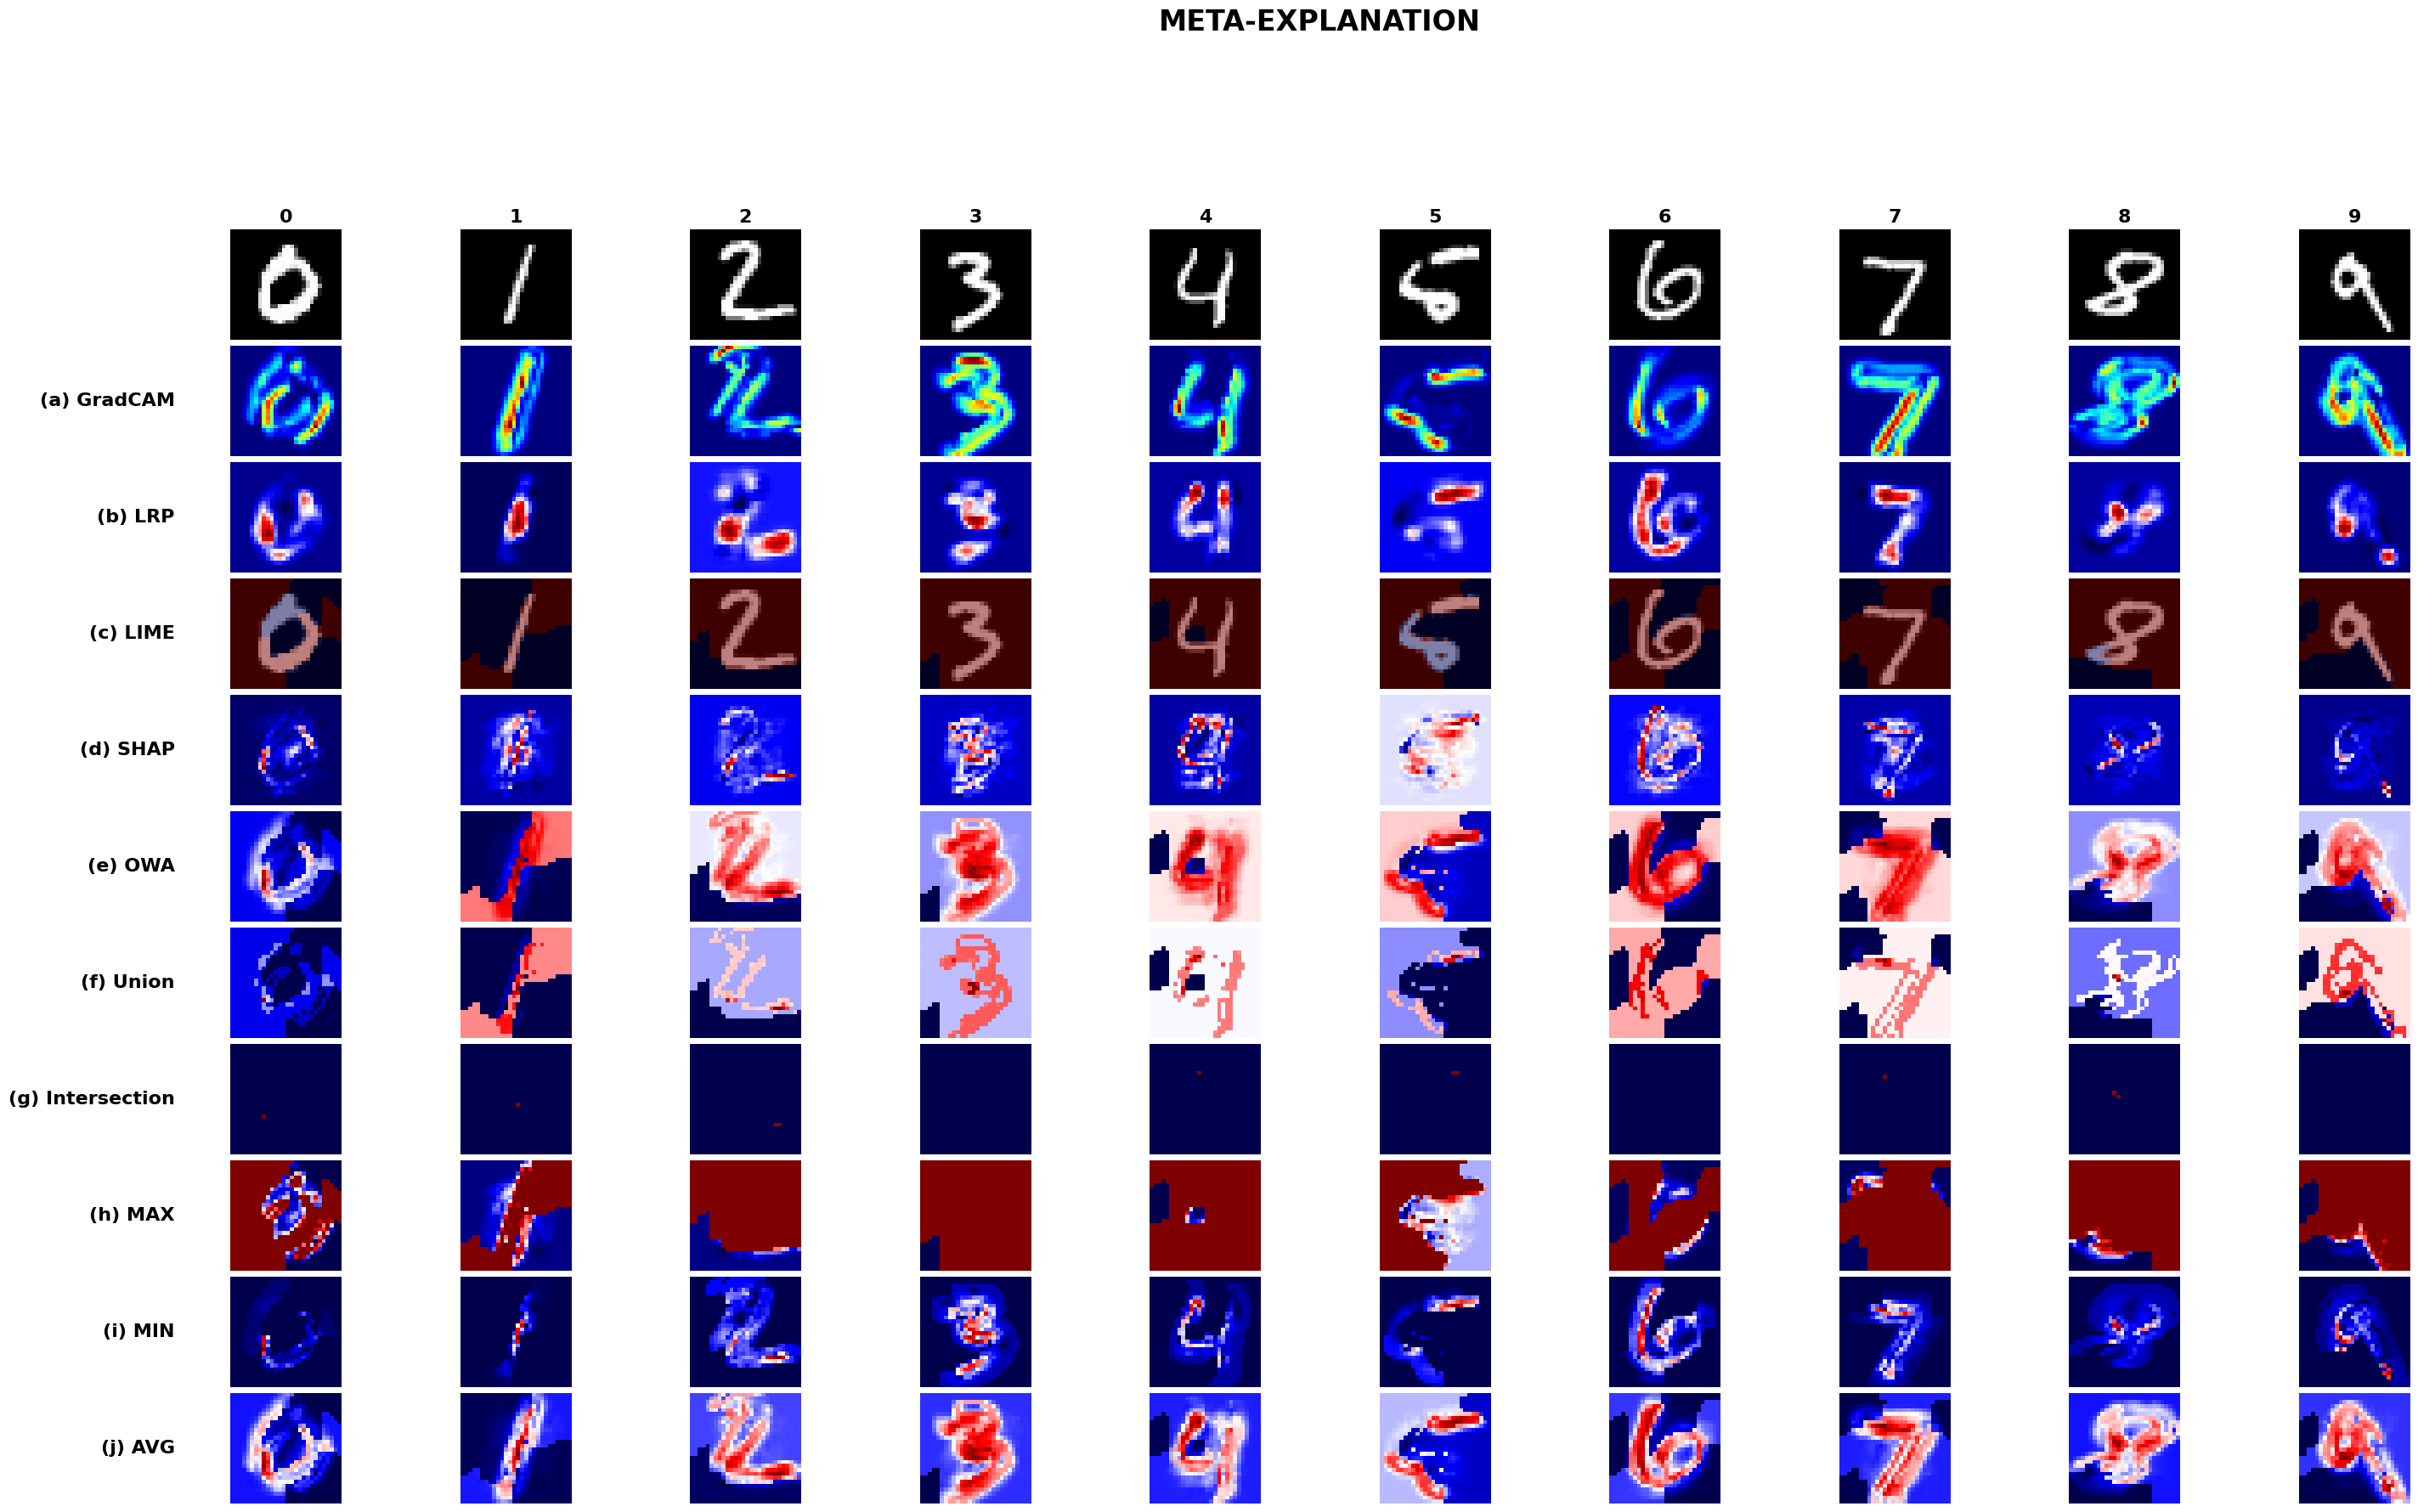

In [35]:
explanations_dict = {
    'GradCAM': new_explanations_data[0]['explanations'],
    'LRP': new_explanations_data[1]['explanations'],
    'LIME': new_explanations_data[2]['explanations'],
    'SHAP': new_explanations_data[3]['explanations'],
    'OWA': integrated_explanations_sum,
    'Union': integrated_explanations_union,
    'Intersection': integrated_explanations_intersection,
    'MAX': max_explanations,
    'MIN': min_explanations,
    'AVG': avg_explanations
}

visualize_explanations_horizontal_with_original(x_selected, y_selected,predictions, explanations_dict, x_selected, y_selected)